In [1]:
import jieba
import glob
import json
import pandas as pd
from pprint import pprint
import gc

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import keras
from keras.models import Model
from keras.models import load_model

import fasttext

pd.set_option('max_colwidth', 30)

C:\Users\edwin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式
print(", ".join(seg_list))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\edwin\AppData\Local\Temp\jieba.cache
Loading model cost 0.767 seconds.
Prefix dict has been built succesfully.


小明, 硕士, 毕业, 于, 中国, 科学, 学院, 科学院, 中国科学院, 计算, 计算所, ，, 后, 在, 日本, 京都, 大学, 日本京都大学, 深造


In [3]:
files = glob.glob('UBS Weibo Data//weibo//Status_Data[1-8].json')
df1 = pd.read_json(files[0], encoding= 'UTF-8')
for i in files[1:]:
    try:
        df1 = df1.append(pd.read_json(i, encoding= 'UTF-8'),ignore_index=True)
    except:
        print(i)

In [4]:
df1.drop_duplicates(inplace=True)

In [5]:
import re
def clean(s):
    ns = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
    return re.sub(r'[^\u4e00-\u9fa5]', '', ns)

In [6]:
df1['clean_text'] = df1['text'].apply(clean)

In [7]:
df1.shape

(6225, 9)

In [8]:
df1.head()

,comments_count,created_at,id,likes_count,retweets_count,status_urls,text,user_id,clean_text
0,2,2015-11-05 16:40:00,D2sqd8hxB,4,9,https://weibo.cn/sinaurl?f...,:@世锦赛汇丰冠军赛 战罢首轮。美国公开赛黑马南非球...,1497996114,世锦赛汇丰冠军赛战罢首轮美国公开赛黑马南非球手布兰登...
1,1,2015-11-05 14:38:00,D2rCGFUkX,3,1,https://weibo.cn/sinaurl?f...,:佘山4号洞，2013年@世锦赛汇丰冠军赛 冠军达斯...,1497996114,佘山号洞年世锦赛汇丰冠军赛冠军达斯汀约翰逊差点上演一...
2,1,2015-11-05 14:18:00,D2ruEc4qv,8,4,https://weibo.cn/sinaurl?f...,:世锦赛-汇丰冠军赛展开首日争夺，中国军团六将梁文冲...,1497996114,世锦赛汇丰冠军赛展开首日争夺中国军团六将梁文冲吴阿顺...
3,1,2017-06-02 10:33:00,F5VQ77jUQ,5,2,http://weibo.cn/pages/1008...,:美巡#纪念高球赛# 首轮最佳球来自瑞奇-福勒18号...,1497996114,美巡纪念高球赛首轮最佳球来自瑞奇福勒号洞果岭沙坑切球...
4,0,2017-06-02 09:54:00,F5VAappkl,4,0,https://weibo.cn/sinaurl?f...,:威巡REX医院公开赛首轮，@张新军golf 开局连...,1497996114,威巡医院公开赛首轮张新军开局连续抓到只小鸟最终交出杆...


In [9]:
uid_dum = pd.get_dummies(df1.user_id)

In [10]:
df1 = pd.merge(df1,uid_dum, left_index=True, right_index=True)

In [11]:
label = pd.read_csv('UBS Weibo Data//weibo//train_label.txt', sep='\t', header=None, names=['id','useless','label'])

In [12]:
label.drop(columns='useless', inplace=True)

In [13]:
label.shape

(1230, 2)

In [14]:
label.head(10)

,id,label
0,zDmYsgBUj,1
1,A6xDl9OxK,10
2,G9Kvsuqb0,6
3,GfESp97V3,4
4,FFHya1f4H,6
5,D3WwHt9ts,9
6,F7uSa36lV,9
7,F6iBLxOme,9
8,GeKvBj0B7,0
9,Fw9iw4FxD,8


In [15]:
train = pd.merge(label,df1,on="id")

In [16]:
train.shape

(1230, 18)

In [17]:
train.head(5)

,id,label,comments_count,created_at,likes_count,retweets_count,status_urls,text,user_id,clean_text,1497996114,1628009324,1881938674,1895520105,1988800805,2308351693,2807239535,5563089830
0,zDmYsgBUj,1,2,2013-06-27 15:52:00,0,1,https://weibo.cn/sinaurl?f...,:【日本基金吸引大量看涨交易】日本智慧树股票型对冲基...,1628009324,日本基金吸引大量看涨交易日本智慧树股票型对冲基金今年...,0,1,0,0,0,0,0,0
1,A6xDl9OxK,10,141,2013-08-26 17:05:00,11,253,https://weibo.cn/sinaurl?f...,:【1299元！小米Pad“紫米”独家真机曝光】据知...,1895520105,元小米紫米独家真机曝光据知情人士爆料之前传闻已久的小...,0,0,0,1,0,0,0,0
2,G9Kvsuqb0,6,11,2018-03-30 11:48:00,83,54,http://weibo.cn/pages/1008...,:#重要展讯# 佳士得隆重宣布5月纽约拍卖的佩吉与大...,2807239535,重要展讯佳士得隆重宣布月纽约拍卖的佩吉与大卫洛克菲勒...,0,0,0,0,0,0,1,0
3,GfESp97V3,4,11,2018-05-08 08:30:00,14,12,https://weibo.cn/sinaurl?f...,:【房产高管薪酬大起底 郁亮年薪1189.9万仅排第...,1988800805,房产高管薪酬大起底郁亮年薪万仅排第二数据显示年房地产...,0,0,0,0,1,0,0,0
4,FFHya1f4H,6,0,2018-01-23 16:22:00,9,2,http://weibo.cn/pages/1008...,:#海外拍场#在1月30日佳士得纽约“经典大师与英伦...,2807239535,海外拍场在月日佳士得纽约经典大师与英伦绘画主题拍卖会...,0,0,0,0,0,0,1,0


In [18]:
test = df1[~df1['id'].isin(train['id'])]

In [19]:
text1 = train.iloc[0].clean_text

In [20]:
seg_list = jieba.cut_for_search(text1)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式

Default Mode: 日本/ 基金/ 吸引/ 大量/ 看涨/ 交易/ 日本/ 智慧/ 树/ 股票/ 型/ 对冲/ 基金/ 今年/ 走势/ 多变/ 昨天/ 该/ 看涨/ 期权/ 再度/ 流通


In [21]:
w2v = pd.read_csv("sgns.weibo.word", header=None, sep=' ')

In [22]:
w2v = w2v.iloc[:,:-1] # ignore the last column with NaN

In [23]:
w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,，,0.094386,-0.200944,-0.030828,0.277130,-0.074674,0.239691,0.345185,0.298053,-0.026679,...,0.111468,-0.078182,-0.201468,-0.049068,-0.030606,0.201523,0.228546,0.003085,0.023796,-0.201742
1,的,-0.124044,-0.053688,0.157958,-0.047875,0.049531,0.184998,0.200833,-0.160882,0.110681,...,0.230547,-0.140871,-0.277111,0.000652,-0.177114,-0.036714,-0.087789,-0.127075,-0.020528,0.032646
2,。,-0.270524,-0.149226,-0.050801,0.014676,-0.391584,0.258038,0.102477,0.004894,0.187659,...,0.104018,0.046463,-0.164107,0.063895,-0.199998,-0.096116,0.381793,0.069962,-0.122410,0.009104
3,@,0.353423,0.341938,-0.132071,-0.030161,-0.216526,-0.143230,0.479183,-0.043970,-0.058509,...,0.199199,-0.342658,-0.057022,-0.445174,-0.324169,0.359802,0.129796,0.302959,-0.025240,0.153184
4,！,0.190794,-0.037967,0.101300,0.251551,-0.055706,0.537454,0.272683,-0.114889,-0.187497,...,0.348889,0.064969,-0.155169,-0.093916,-0.480437,-0.027186,0.095489,-0.302136,-0.126407,-0.178464


In [24]:
w2v.shape

(130198, 301)

In [25]:
w2v.head(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,，,0.094386,-0.200944,-0.030828,0.277130,-0.074674,0.239691,0.345185,0.298053,-0.026679,...,0.111468,-0.078182,-0.201468,-0.049068,-0.030606,0.201523,0.228546,0.003085,0.023796,-0.201742
1,的,-0.124044,-0.053688,0.157958,-0.047875,0.049531,0.184998,0.200833,-0.160882,0.110681,...,0.230547,-0.140871,-0.277111,0.000652,-0.177114,-0.036714,-0.087789,-0.127075,-0.020528,0.032646
2,。,-0.270524,-0.149226,-0.050801,0.014676,-0.391584,0.258038,0.102477,0.004894,0.187659,...,0.104018,0.046463,-0.164107,0.063895,-0.199998,-0.096116,0.381793,0.069962,-0.122410,0.009104
3,@,0.353423,0.341938,-0.132071,-0.030161,-0.216526,-0.143230,0.479183,-0.043970,-0.058509,...,0.199199,-0.342658,-0.057022,-0.445174,-0.324169,0.359802,0.129796,0.302959,-0.025240,0.153184
4,！,0.190794,-0.037967,0.101300,0.251551,-0.055706,0.537454,0.272683,-0.114889,-0.187497,...,0.348889,0.064969,-0.155169,-0.093916,-0.480437,-0.027186,0.095489,-0.302136,-0.126407,-0.178464
5,了,-0.265306,-0.012128,0.054369,0.161182,0.108999,0.228060,0.264748,0.220678,-0.006794,...,0.021784,-0.158714,-0.425785,-0.140036,-0.285551,-0.005943,-0.025092,-0.377171,0.173581,-0.062289
6,、,0.272173,0.171626,0.095834,0.240955,0.039931,0.270726,0.037028,-0.416159,0.210513,...,0.412781,0.176128,-0.387214,-0.352446,0.027390,-0.041767,0.262398,0.123831,-0.402550,-0.132707
7,：,0.266232,-0.080174,-0.088479,0.109880,-0.067911,-0.366643,0.246686,-0.091920,-0.339914,...,-0.071100,-0.359892,-0.445297,0.247915,-0.089938,0.195544,-0.249174,-0.377216,-0.351070,-0.241822
8,】,-0.128490,-0.329927,-0.124422,0.065912,0.008610,0.599650,0.503155,0.337174,0.027491,...,-0.219551,0.020339,-0.086581,0.184960,-0.054858,-0.179416,0.088097,0.126182,-0.554329,-0.328050
9,是,0.044646,-0.405991,0.291613,0.212346,0.007146,0.187809,0.256465,0.062414,0.158558,...,0.125973,0.208694,-0.336005,-0.127605,0.164675,0.084039,0.268366,-0.113530,-0.101131,0.371861


In [26]:
# creating a dictionary with word and an array of the corresponding vector
embeddings_index = dict()
for i in range(w2v.shape[0]):
    word = w2v.iloc[i,0]
    coefs = np.asarray(w2v.iloc[i,1:], dtype='float32')
    embeddings_index[word] = coefs

In [27]:
words = []
for i in range(df1.shape[0]):
    for j in jieba.cut_for_search(df1.iloc[i]["clean_text"]):
        words.append(j)

In [28]:
words = list(set(words))

In [29]:
# Put in function to remove stop words

file = open('chinese_stopwords_2.txt','rb').read().decode('utf8').split('\n')
stop_words = list(set(file))

In [30]:
def rm_tokens(words): # 去掉一些停用次和数字
    words_list = list(words)
    for i in range(len(words_list))[::-1]:
        if words_list[i] in stop_words: # 去除停用词
            words_list.pop(i)
        elif words_list[i].isdigit():
            words_list.pop(i)
    return words_list

In [31]:
range(len(words))[::-1]

range(40589, -1, -1)

In [32]:
words = rm_tokens(words)

In [33]:
len(words)

39536

In [34]:
t = Tokenizer()
t.fit_on_texts(words)
vocab_size = len(t.word_index) + 1

In [35]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix[324]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
X = train.clean_text
X_test = test.clean_text

In [38]:
X1 = []
for i in X:
    X1.append(rm_tokens([j for j in jieba.cut_for_search(i)]))
X1_test = []
for i in X_test:
    X1_test.append(rm_tokens([j for j in jieba.cut_for_search(i)]))

In [39]:
X1[:2]

[['日本',
  '基金',
  '吸引',
  '看涨',
  '交易',
  '日本',
  '智慧',
  '树',
  '股票',
  '型',
  '对冲',
  '基金',
  '走势',
  '多变',
  '昨天',
  '看涨',
  '期权',
  '再度',
  '流通'],
 ['元',
  '小米',
  '紫米',
  '独家',
  '真机',
  '曝光',
  '知情',
  '人士',
  '爆料',
  '已久',
  '小米',
  '平板',
  '紫米',
  '参加',
  '月',
  '号',
  '新品',
  '发布',
  '发布会',
  '配备',
  '四核',
  '理器',
  '处理器',
  '内存',
  '存储',
  '前置',
  '后置',
  '摄像',
  '像头',
  '摄像头',
  '寸',
  '视网',
  '网膜',
  '视网膜',
  '屏幕',
  '售价',
  '依旧',
  '给力',
  '元',
  '详情']]

In [40]:
encoded_docs = t.texts_to_sequences(X1)
padded_docs_combined = pad_sequences(encoded_docs, maxlen=100, padding='post')

In [41]:
encoded_docs[:2]

[[20963,
  34287,
  18867,
  29040,
  17631,
  20963,
  29588,
  26546,
  10878,
  38546,
  36977,
  34287,
  4503,
  39127,
  12484,
  29040,
  24719,
  20543,
  24712],
 [30514,
  23864,
  19187,
  34667,
  1854,
  25373,
  24650,
  32734,
  28553,
  33269,
  23864,
  35064,
  19187,
  8191,
  33732,
  19647,
  4420,
  6398,
  30673,
  22906,
  28158,
  14277,
  5613,
  33788,
  18551,
  11056,
  23360,
  23509,
  152,
  959,
  30504,
  6562,
  1157,
  11102,
  28017,
  38943,
  34340,
  12464,
  30514,
  4627]]

In [42]:
encoded_docs_test = t.texts_to_sequences(X1_test)
padded_docs_combined_test = pad_sequences(encoded_docs_test, maxlen=100, padding='post')

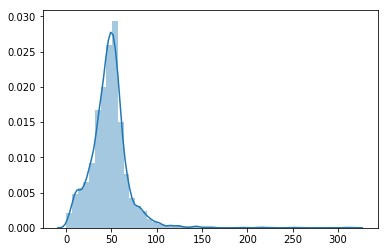

In [43]:
sns.distplot([len(i) for i in encoded_docs_test ])

In [44]:
train_len = 800

In [45]:
df_train_padded = padded_docs_combined
df_test_padded = padded_docs_combined_test

In [46]:
print(df_train_padded.shape)
print(df_test_padded.shape)

(1230, 100)
(4995, 100)


In [47]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'f1' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'f1' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('f1')
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.legend()
    plt.show()

In [48]:
X_train_text = df_train_padded
X_train_uid = train.iloc[:,10:]
y_train = pd.get_dummies(train.label)

X_test_text = df_test_padded
X_test_uid = test.iloc[:,9:]

In [49]:
X_test_uid.shape

(4995, 8)

In [50]:
"""
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], 
                  input_length=100, trainable=True)
model.add(e)
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(13, activation='softmax'))
"""

"\nmodel = Sequential()\ne = Embedding(vocab_size, 300, weights=[embedding_matrix], \n                  input_length=100, trainable=True)\nmodel.add(e)\nmodel.add(Conv1D(128, 3, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Flatten())\nmodel.add(Dense(13, activation='softmax'))\n"

In [51]:

main_input = Input(shape=(100,), dtype='int32', name='main_input')

x = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=True)(main_input)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
conv_out = Flatten()(x)

auxiliary_input = Input(shape=(8,), name='aux_input')
x = keras.layers.concatenate([conv_out, auxiliary_input])

x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

main_output = Dense(13, activation='softmax')(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [52]:
# define function to calculate F1 score

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [53]:
# load saved model
#model = load_model('ubs_model.h5')

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     11861100    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      115328      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 32, 128)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [55]:
model.compile(loss='categorical_crossentropy',
          optimizer= "adam",
          metrics=[f1])

In [56]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)
history = model.fit([X_train_text, X_train_uid], y_train, validation_split=0.25,
                        epochs=100, verbose=1, callbacks=[es])

Train on 922 samples, validate on 308 samples
Epoch 1/100
922/922 [==============================] - 3s 4ms/step - loss: 2.2807 - f1: 0.0062 - val_loss: 1.9624 - val_f1: 0.0000e+00
Epoch 2/100
922/922 [==============================] - 1s 1ms/step - loss: 1.8275 - f1: 0.1616 - val_loss: 1.4860 - val_f1: 0.3824
Epoch 3/100
922/922 [==============================] - 1s 1ms/step - loss: 1.3650 - f1: 0.5340 - val_loss: 1.1655 - val_f1: 0.5672
Epoch 4/100
922/922 [==============================] - 1s 1ms/step - loss: 1.0764 - f1: 0.6238 - val_loss: 1.0002 - val_f1: 0.6065
Epoch 5/100
922/922 [==============================] - 1s 1ms/step - loss: 0.7956 - f1: 0.7038 - val_loss: 0.8646 - val_f1: 0.6477
Epoch 6/100
922/922 [==============================] - 1s 1ms/step - loss: 0.6177 - f1: 0.7868 - val_loss: 0.7839 - val_f1: 0.6720
Epoch 7/100
922/922 [==============================] - 1s 1ms/step - loss: 0.4636 - f1: 0.8349 - val_loss: 0.7249 - val_f1: 0.7302
Epoch 8/100
922/922 [============

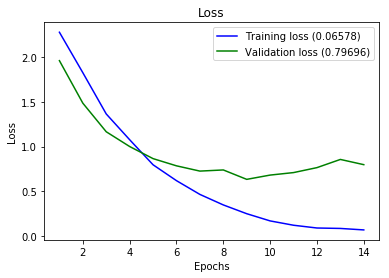

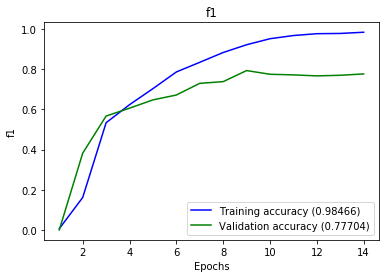

In [57]:
plot_history(history)

In [58]:
# save model as...
model.save('ubs_model.h5')  

In [59]:
y_pred = model.predict([X_test_text, X_test_uid])

In [60]:
np.argmax(y_pred, axis=1)

array([ 9,  9,  9, ..., 12, 12, 10], dtype=int64)

In [61]:
test['predict'] = np.argmax(y_pred, axis=1)

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
test.sample(10)[["clean_text","predict"]]

,clean_text,predict
1075,亚洲可能不是好年景中国韩国印度尼西亚和印度最新的采购...,4
2076,每个后小时候总有一两张不堪回首的照,10
6294,考研季距离考研不足天你准备好了吗并不简单本月日日考研...,12
950,知名投资者高盛集团资产管理业务主席吉姆奥尼尔卸任在卸...,1
4480,佳士得国际偶遇佳士得拍卖用车的运输车英国,10
6665,被数学耽误的灵魂画手高三数学老师将知识点画成国王与王...,12
5684,佳士得春季拍卖两专场共实现人民币元美元的总成交额邬一...,5
4693,新一季拍卖季即将开始家中藏宝希望上拍如何委托如何联系...,8
6815,大家期待已久的创客教育产业全图上架啦挤眼挤眼挤眼挤眼...,10
6231,中国好老师听课认真有红包我也想上这些老师的课羞嗒嗒大...,12


In [63]:
test['user_id'].unique()

array([1497996114, 1628009324, 1881938674, 1895520105, 1988800805,
       2308351693, 2807239535, 5563089830], dtype=int64)

In [64]:
train['label'].value_counts()

10    320
9     238
8     216
0     102
5      66
6      62
1      55
12     46
4      44
11     34
7      26
2      11
3      10
Name: label, dtype: int64

In [65]:
# Car KOL
test[['clean_text','user_id','predict']][test['user_id']==1895520105].shape[0]

348

In [66]:
# Car KOL pred
test[['clean_text','user_id','predict']][test['user_id']==1895520105][test['predict']==10].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


328

In [67]:
# Golf KOL
test[['clean_text','user_id','predict']][test['user_id']==1497996114].shape[0]

221

In [68]:
# Golf KOL pred
test[['clean_text','user_id','predict']][test['user_id']==1497996114][test['predict']==9].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


212

In [69]:
# Education KOL
test[['clean_text','user_id','predict']][test['user_id']==5563089830].shape[0]

1340

In [70]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['user_id']==5563089830][test['predict']==11].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


275

In [71]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['user_id']==5563089830][test['predict']==12].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


664

In [72]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['predict']==3]

,clean_text,user_id,predict
415,据京华时报报道中央纪委监察部网站日前通报了年中央巡视...,1497996114,3
490,全球可可市场或供应不足领先的可可交易商奥兰国际周一警...,1628009324,3
556,税负最重的国家根据毕马威会计事务所年的调查报告赋税最...,1628009324,3
561,英文视频谁将成为哈佛的下一个扎克伯格采访了大三创立的...,1628009324,3
567,萨马拉斯我们与欧元区紧紧联系希腊新民主党领袖萨马拉斯...,1628009324,3
627,坐拥百万美元豪宅的岁偶像中文网曾刊登过巴菲特价值万美...,1628009324,3
637,中国超富人群财富缩水饮料大王宗庆曾在年高居财富榜榜首...,1628009324,3
651,快讯本台消息奥巴马赢得本次美国总统选举,1628009324,3
717,香港迪士尼乐园新景点开放世界最小的迪士尼乐园香港迪士...,1628009324,3
719,欧元集团主席法国需要加速改革上周六七国财长和央行官员...,1628009324,3


In [73]:
output = test[['id','predict']]

In [74]:
output.to_csv('prediction.txt', header=False, index=False, sep="\t")

In [75]:
gc.collect()

21

In [76]:
comment = pd.read_json('UBS Weibo Data//weibo//Status_Data9_Comment_Data_with_city_code.json', encoding= 'UTF-8')
task = pd.read_json('UBS Weibo Data//weibo//task-status.json', encoding= 'UTF-8')
city = pd.read_json('UBS Weibo Data//weibo//weibo-china-province-city.json', encoding= 'UTF-8')

In [77]:
comment.head()

,cid,u_city,u_name,u_province,uid
0,G6RevbiBE,2,了不起的查尔斯,11,5048555731
1,G6RevbiBE,5,Pokerface1001,11,3211419333
2,G6RevbiBE,2,了不起的查尔斯,11,5048555731
3,G6QJ1aa2Z,3,飞马1515,44,5583941399
4,G9Ob5sz8r,1000,原来是酱紫的呀,400,5364706506


In [78]:
comment.shape

(17400, 5)

In [79]:
task.sample(10)

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid
2805,6,2018-03-11 06:32:00,15,9,:【估值总计超3万亿元 国内“独角兽”企业有哪些？】...,G6SsMcmA9,凤凰网财经,1988800805
970,33,2018-03-28 02:35:00,17,17,:#爱极客# #2018纽约车展# 【美版全新卡罗拉...,G9raTAh7x,爱极客,1895520105
29,4,2018-03-01 02:45:00,8,12,:【中国2月财新制造业PMI 51.6 好于预期】财...,G5kHr2sWp,凤凰网财经,1988800805
1871,0,2018-02-24 14:50:00,1,0,:#卡塔尔公开赛#结束移动日争夺。英格兰双雄埃迪-佩...,G4EjmzB1j,新浪高尔夫,1497996114
4796,0,2018-03-18 06:27:00,10,2,:#2018春拍##香港蘇富比#现代艺术晚拍将于3月...,G7WpZuzbg,蘇富比拍卖行,2308351693
1540,9,2018-02-01 01:41:00,56,8,:【[话筒]备战公考的同学请注意[话筒]，有一个大“...,G14jAoofU,微博教育,5563089830
3480,22,2018-03-17 15:00:00,87,38,:【凤凰 晚安】创造机会的人是勇者，等待机会的人是愚...,G7QlIqJbn,凤凰网财经,1988800805
3883,2,2018-03-22 05:30:00,5,7,:【中国寿险业新纪元！一场盛会即将召开】中国加入WT...,G8xKQ0JfK,凤凰网财经,1988800805
3945,32,2018-03-23 04:30:00,19,23,:【日本经济产业大臣：已一再请求美国豁免日本的关税】...,G8GMYyseg,凤凰网财经,1988800805
4291,20,2018-03-31 09:50:00,37,24,:【刘明：区块链可能90%几以上是骗局】谈到若以太坊...,G9WiQ6C1M,凤凰网财经,1988800805


In [80]:
task.head(5)

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid
0,20,2018-02-28 23:59:00,16,16,":【科技独角兽IPO""即报即审""？10大巨头万亿市值...",G5jCq7d7M,凤凰网财经,1988800805
1,10,2018-03-19 01:43:00,21,8,:宝骏530前一阵子刚刚公布了售价，并且外形采用了和...,G83Zh7dWB,爱极客,1895520105
2,63,2018-02-09 04:20:00,36,114,:【恒大打响2018房企大规模促销第一枪 全国楼盘8...,G2iM478Ip,凤凰网财经,1988800805
3,1,2018-04-07 05:40:00,11,2,:#美国大师赛#15号洞(没错，就是加西亚爆出+8那...,GaYEQ8hI3,新浪高尔夫,1497996114
4,31,2018-02-09 03:56:00,19,14,:【午评：权重跳水个股普跌 沪指重挫近6%后回升】受...,G2iCowAOT,凤凰网财经,1988800805


In [81]:
task['clean_text'] = task['s_text'].apply(clean)
uid_dum = pd.get_dummies(task.uid)
task = pd.merge(task,uid_dum, left_index=True, right_index=True)

In [82]:
X_task = []
for i in task.clean_text:
    X_task.append(rm_tokens([j for j in jieba.cut_for_search(i)]))
    
encoded_docs_task = t.texts_to_sequences(X_task)
padded_docs_combined_task = pad_sequences(encoded_docs_task, maxlen=100, padding='post')

In [83]:
X_task_text = padded_docs_combined_task
X_task_uid = task.iloc[:,9:]

In [84]:
for i in X_test_uid.columns:
    if i not in X_task_uid.columns:
        X_task_uid[i] = np.zeros(X_task_uid.shape[0])
        X_task_uid[i] = X_task_uid[i].apply(int).apply(str)

In [85]:
X_task_uid = X_task_uid.reindex_axis(sorted(X_test_uid.columns), axis=1)

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [86]:
X_task_uid.head()

,1497996114,1628009324,1881938674,1895520105,1988800805,2308351693,2807239535,5563089830
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [87]:
y_pred = model.predict([X_task_text, X_task_uid])

In [88]:
task['predict'] = np.argmax(y_pred, axis=1)

In [89]:
task.head()

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid,clean_text,1497996114,1895520105,1988800805,2308351693,2807239535,5563089830,predict
0,20,2018-02-28 23:59:00,16,16,":【科技独角兽IPO""即报即审""？10大巨头万亿市值...",G5jCq7d7M,凤凰网财经,1988800805,科技独角兽即报即审大巨头万亿市值待开发前有借壳今日正...,0,0,1,0,0,0,0
1,10,2018-03-19 01:43:00,21,8,:宝骏530前一阵子刚刚公布了售价，并且外形采用了和...,G83Zh7dWB,爱极客,1895520105,宝骏前一阵子刚刚公布了售价并且外形采用了和一样的家族...,0,1,0,0,0,0,10
2,63,2018-02-09 04:20:00,36,114,:【恒大打响2018房企大规模促销第一枪 全国楼盘8...,G2iM478Ip,凤凰网财经,1988800805,恒大打响房企大规模促销第一枪全国楼盘折优惠恒大已在房...,0,0,1,0,0,0,8
3,1,2018-04-07 05:40:00,11,2,:#美国大师赛#15号洞(没错，就是加西亚爆出+8那...,GaYEQ8hI3,新浪高尔夫,1497996114,美国大师赛号洞没错就是加西亚爆出那一洞马克利什曼成功...,1,0,0,0,0,0,9
4,31,2018-02-09 03:56:00,19,14,:【午评：权重跳水个股普跌 沪指重挫近6%后回升】受...,G2iCowAOT,凤凰网财经,1988800805,午评权重跳水个股普跌沪指重挫近后回升受海外股市低迷影...,0,0,1,0,0,0,0


In [90]:
output = task[['sid','predict']]
output.to_csv('prediction2.txt', header=False, index=False, sep="\t")

In [91]:
output.head()

,sid,predict
0,G5jCq7d7M,0
1,G83Zh7dWB,10
2,G2iM478Ip,8
3,GaYEQ8hI3,9
4,G2iCowAOT,0


In [92]:
output = task[['sid','predict','likes_count','retweets_count']]
output.to_csv('task.txt', header=False, index=False, sep="\t")

In [93]:
df = pd.read_csv('prediction.txt',header=None, sep='\t').append(pd.read_csv('prediction2.txt',header=None, sep='\t'), ignore_index=True)

In [94]:
df = df.drop_duplicates()

In [95]:
df.to_csv("final_prediction.txt", header=False, index=False, sep="\t", encoding="utf-8-sig")

### Using gensim wrapper to load FastText pretrained chinese word embeddings

In [96]:
import fasttext
import gensim
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors

C:\Users\edwin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [97]:
model_ft = FastText.load_fasttext_format('C:/Users/edwin/Desktop/FastText/wiki.zh.bin')
#print model.words # list of words in dictionary


In [98]:
print(model_ft)

FastText(vocab=332647, size=300, alpha=0.025)


In [99]:
model_ft.most_similar('傻子')

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('︶', 0.9985238313674927),
 ('谝', 0.9984948635101318),
 ('들', 0.998481035232544),
 ('॥', 0.9984743595123291),
 ('硬幹', 0.998470664024353),
 ('정', 0.9984679222106934),
 ('馬荷', 0.998467206954956),
 ('毛坑', 0.9984552264213562),
 ('嗾', 0.9984531402587891),
 ('平允', 0.9984499216079712)]

In [100]:
# Remove their stopwords.
#from nltk.corpus import stopwords
#stopwords = stopwords.words('chinese')

In [101]:
word_vectors = model_ft.wv

In [102]:
word_list = []
for word in model_ft.wv.vocab:
    word_list.append(word)

In [103]:
len(word_list)

332647

In [104]:
word_list

['</s>',
 '，',
 '的',
 '。',
 '-',
 '年',
 "'",
 '（',
 '）',
 '}',
 '、',
 '.',
 '月',
 ')',
 '(',
 '日',
 '在',
 '：',
 '是',
 ',',
 'name',
 'wikidata',
 '/',
 '"',
 '和',
 '#',
 '》',
 '《',
 'q',
 '了',
 '·',
 '村',
 '人',
 '%',
 '中',
 'arg',
 '小行星',
 '为',
 'original',
 '」',
 '「',
 '為',
 'utc',
 'rd',
 '被',
 '斯',
 '有',
 '及',
 '於',
 '第',
 '與',
 '以',
 '上',
 '而',
 '由',
 '大',
 '特',
 'score',
 '之',
 '科',
 '他',
 '；',
 '于',
 '—',
 '至',
 '地',
 '尔',
 '德',
 '等',
 '重',
 '一',
 '一个',
 '\\',
 '其',
 '定向',
 '但',
 '中国',
 'a',
 '下',
 'the',
 '也',
 '名',
 '拉',
 '後',
 '到',
 '留言',
 '市',
 '与',
 '克',
 'align',
 '后',
 '新',
 'e',
 '或',
 '香港',
 '站',
 '時',
 '州',
 '研究',
 '罗',
 '日本',
 '者',
 '三',
 '县',
 'of',
 '前',
 '－',
 '家',
 '所',
 '近',
 '米',
 '多',
 '使用',
 '会',
 '–',
 '基',
 '区',
 '阿',
 '王',
 '可以',
 '林',
 '已',
 '公司',
 '个',
 '李',
 '索',
 '\u3000',
 '一個',
 '天',
 '西',
 '省',
 '度',
 '卡',
 '并',
 '社区',
 '爾',
 '该',
 'b',
 '二',
 '小',
 '相似',
 '时',
 '區',
 '不',
 '並',
 '部',
 '里',
 '人口',
 '四',
 '政府',
 'center',
 '都',
 '會',
 '其中',
 '尼',
 '？',

In [105]:
word_list[1000]

'不過'

In [106]:
model_ft[word_list[1000]]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-2.10990012e-01,  5.00070274e-01, -4.06733602e-01,  9.21593606e-02,
        6.16476178e-01, -2.83259362e-01, -4.96694744e-01,  1.00771144e-01,
        2.51273930e-01, -1.28851831e-01,  7.77843833e-01,  1.11950591e-01,
        9.71795082e-01, -7.48215258e-01,  1.39022628e-02, -5.43026209e-01,
        7.43815005e-01, -2.85781533e-01, -9.32675004e-01, -5.74889600e-01,
       -5.77737093e-01,  7.27206469e-01,  7.31991231e-01, -2.44006868e-02,
        6.93525732e-01, -4.68766779e-01,  8.99220824e-01,  9.48127806e-02,
        4.28343207e-01,  1.18984096e-01,  9.94310021e-01, -6.81939900e-01,
       -7.69493878e-01, -7.31878042e-01, -5.95577359e-01,  7.93085814e-01,
        8.63505960e-01, -3.52426499e-01, -9.21095684e-02,  8.45404804e-01,
        6.08381867e-01,  8.77255380e-01,  1.00067580e+00, -1.11532390e+00,
       -2.33211234e-01, -4.58435178e-01, -5.14300168e-01, -3.59995604e-01,
        3.84000033e-01, -6.58116519e-01,  1.06407058e+00, -1.96861327e-01,
       -3.79014999e-01, -

In [107]:
# creating a dictionary with word and an array of the corresponding vector

embeddings_index2 = dict()
for i in range(len(word_list)):
    word = word_list[i]
    embeddings_index2[word] = np.asarray(model_ft[word], dtype='float32')


C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [108]:
embedding_matrix2 = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index2.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector

In [109]:

main_input = Input(shape=(100,), dtype='int32', name='main_input')

x = Embedding(vocab_size, 300, weights=[embedding_matrix2], input_length=100, trainable=True)(main_input)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
conv_out = Flatten()(x)

auxiliary_input = Input(shape=(8,), name='aux_input')
x = keras.layers.concatenate([conv_out, auxiliary_input])

x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

main_output = Dense(13, activation='softmax')(x)

model2 = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

In [110]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     11861100    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 98, 128)      115328      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 19, 128)      0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
dropout_3 

In [111]:
model2.compile(loss='categorical_crossentropy',
          optimizer= "adam",
          metrics=[f1])

In [112]:
es = EarlyStopping(patience=10)
history = model2.fit([X_train_text, X_train_uid], y_train, validation_split=0.25,
                        epochs=100, verbose=1, callbacks=[es])

Train on 922 samples, validate on 308 samples
Epoch 1/100
922/922 [==============================] - 2s 2ms/step - loss: 2.5092 - f1: 0.0199 - val_loss: 2.2085 - val_f1: 0.0000e+00
Epoch 2/100
922/922 [==============================] - 1s 1ms/step - loss: 2.1140 - f1: 0.0908 - val_loss: 2.0002 - val_f1: 0.0000e+00
Epoch 3/100
922/922 [==============================] - 1s 1ms/step - loss: 1.9409 - f1: 0.1380 - val_loss: 1.8296 - val_f1: 0.0901
Epoch 4/100
922/922 [==============================] - 1s 1ms/step - loss: 1.8405 - f1: 0.1941 - val_loss: 1.6558 - val_f1: 0.1902
Epoch 5/100
922/922 [==============================] - 1s 1ms/step - loss: 1.6912 - f1: 0.3129 - val_loss: 1.5164 - val_f1: 0.2445
Epoch 6/100
922/922 [==============================] - 1s 1ms/step - loss: 1.5270 - f1: 0.4335 - val_loss: 1.3535 - val_f1: 0.5337
Epoch 7/100
922/922 [==============================] - 1s 1ms/step - loss: 1.3662 - f1: 0.5333 - val_loss: 1.2195 - val_f1: 0.6345
Epoch 8/100
922/922 [========

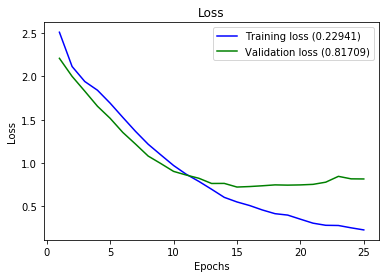

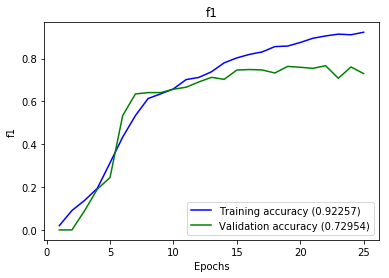

In [113]:
plot_history(history)

In [114]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [115]:
w = train['label'].value_counts()/train['label'].value_counts().sum()
w = w.max()/w

In [116]:
weights = w.sort_index().values

In [117]:
loss = weighted_categorical_crossentropy(weights)

In [118]:
main_input = Input(shape=(100,), dtype='int32', name='main_input')

x = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=False)(main_input)
x = Conv1D(128, 5, activation='softmax')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5, activation='softmax')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
conv1_out = BatchNormalization()(Flatten()(x))

x = Embedding(vocab_size, 300, weights=[embedding_matrix2], input_length=100, trainable=False)(main_input)
x = Conv1D(128, 5, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
conv2_out = BatchNormalization()(Flatten()(x))

auxiliary_input = Input(shape=(8,), name='aux_input')
x = keras.layers.concatenate([conv1_out, conv2_out, auxiliary_input])

x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(13, activation='softmax')(x)

model3 = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

In [119]:
model3.compile(loss=loss,
          optimizer= "adam",
          metrics=[f1])

In [120]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     11861100    main_input[0][0]                 
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     11861100    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 128)      192128      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_7 (

In [121]:
es = EarlyStopping(patience=100)
history = model3.fit([X_train_text, X_train_uid], y_train, validation_split=0.1,
                        epochs=100, verbose=1, callbacks=[es])

Train on 1107 samples, validate on 123 samples
Epoch 1/100
1107/1107 [==============================] - 4s 4ms/step - loss: 8.9914 - f1: 0.0000e+00 - val_loss: 7.4383 - val_f1: 0.0000e+00
Epoch 2/100
1107/1107 [==============================] - 1s 1ms/step - loss: 8.1282 - f1: 0.0104 - val_loss: 7.0411 - val_f1: 0.0000e+00
Epoch 3/100
1107/1107 [==============================] - 1s 1ms/step - loss: 7.4296 - f1: 0.0358 - val_loss: 5.8880 - val_f1: 0.0157
Epoch 4/100
1107/1107 [==============================] - 1s 1ms/step - loss: 6.4008 - f1: 0.1110 - val_loss: 5.7769 - val_f1: 0.2642
Epoch 5/100
1107/1107 [==============================] - 1s 1ms/step - loss: 5.5086 - f1: 0.2132 - val_loss: 4.6139 - val_f1: 0.4182
Epoch 6/100
1107/1107 [==============================] - 1s 1ms/step - loss: 4.7815 - f1: 0.2987 - val_loss: 4.2552 - val_f1: 0.5031
Epoch 7/100
1107/1107 [==============================] - 1s 1ms/step - loss: 4.2409 - f1: 0.4187 - val_loss: 4.1384 - val_f1: 0.5679
Epoch 8/10

Epoch 62/100
1107/1107 [==============================] - 1s 1ms/step - loss: 0.2697 - f1: 0.9632 - val_loss: 3.3413 - val_f1: 0.8183
Epoch 63/100
1107/1107 [==============================] - 1s 984us/step - loss: 0.2151 - f1: 0.9714 - val_loss: 2.5035 - val_f1: 0.8130
Epoch 64/100
1107/1107 [==============================] - 1s 1ms/step - loss: 0.2533 - f1: 0.9759 - val_loss: 3.7060 - val_f1: 0.8197
Epoch 65/100
1107/1107 [==============================] - 1s 1ms/step - loss: 0.2249 - f1: 0.9659 - val_loss: 3.1828 - val_f1: 0.8116
Epoch 66/100
1107/1107 [==============================] - 1s 1ms/step - loss: 0.1939 - f1: 0.9773 - val_loss: 5.1301 - val_f1: 0.8028
Epoch 67/100
1107/1107 [==============================] - 2s 1ms/step - loss: 0.1801 - f1: 0.9768 - val_loss: 3.1540 - val_f1: 0.8293
Epoch 68/100
1107/1107 [==============================] - 1s 921us/step - loss: 0.1594 - f1: 0.9805 - val_loss: 3.1508 - val_f1: 0.8602
Epoch 69/100
1107/1107 [==============================] - 

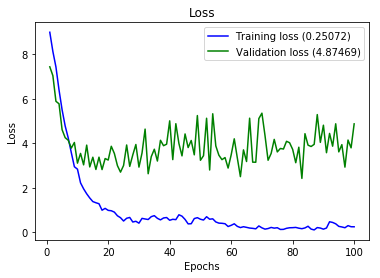

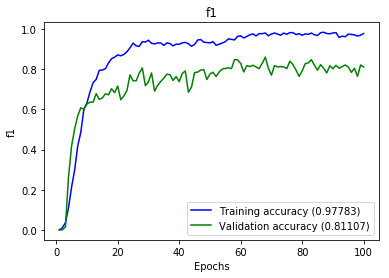

In [122]:
plot_history(history)